<a href="https://colab.research.google.com/github/samandarmaxsutov/Colab-and-Matplotlib-python/blob/main/notebooks/train-yolov12-object-detection-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [3]:
import os


os.environ["ROBOFLOW_API_KEY"] = "RFS8fg4bZk1TE7h3hKgA"


### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [4]:
!nvidia-smi

Sat Feb 22 12:24:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [6]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="RFS8fg4bZk1TE7h3hKgA")
project = rf.workspace("sorting-medicines").project("pills-1wv6s")
version = project.version(3)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pills-3 in yolov12:: 100%|██████████| 360/360 [00:00<00:00, 2860.32it/s]


In [8]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [9]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['damaged_pills', 'pills']

roboflow:
  workspace: sorting-medicines
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [10]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Pills-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True,

100%|██████████| 755k/755k [00:00<00:00, 10.1MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689408  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.34M/5.34M [00:00<00:00, 294MB/s]


AMP: checks passed ✅


train: Scanning /content/Pills-3/train/labels... 122 images, 1 backgrounds, 0 corrupt: 100%|██████████| 122/122 [00:00<00:00, 2046.55it/s]

train: New cache created: /content/Pills-3/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Pills-3/valid/labels... 35 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35/35 [00:00<00:00, 1820.22it/s]

val: New cache created: /content/Pills-3/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/8 [00:00<?, ?it/s]Memory Efficient attention defaults to a non-deterministic algorithm. To explicitly enable determinism call torch.use_deterministic_algorithms(True, warn_only=False). (Triggered internally at ../aten/src/ATen/native/transformers/cuda/attention_backward.cu:655.)
      1/100      5.41G      6.466      7.746      4.169        218        640: 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.25G      6.419      7.602      4.108        232        640: 100%|██████████| 8/8 [00:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.26G      6.421      7.258      3.977        232        640: 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.22G      6.307      7.295      3.841        164        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       5.2G      5.784      5.906      3.532        245        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.19G      4.533      4.431      3.031        141        640: 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.22G      3.577      3.038      2.638        148        640: 100%|██████████| 8/8 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.27G      3.215      2.451      2.255        223        640: 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.27G      2.825      1.884      1.911        174        640: 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.24G      2.464      1.614      1.631        164        640: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.23G      2.173      1.473      1.509        131        640: 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.34G      2.435      1.448       1.49        227        640: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.32G      2.147       1.42      1.394        149        640: 100%|██████████| 8/8 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         35        531          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.34G       2.19      1.374       1.33        205        640: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]

                   all         35        531   0.000866    0.00551   0.000438   0.000227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.25G      1.972      1.286      1.287        173        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         35        531     0.0494      0.802        0.1     0.0349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.27G      1.835      1.251      1.288        118        640: 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         35        531     0.0542       0.87      0.414      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.25G      1.798      1.117      1.214        178        640: 100%|██████████| 8/8 [00:03<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         35        531       0.54      0.443       0.61       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.25G      1.708       1.18      1.192        211        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         35        531      0.814      0.601      0.709      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.23G       1.66       1.09       1.19        171        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         35        531      0.768      0.621      0.705      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.27G      1.463      1.009      1.139        176        640: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         35        531      0.631      0.705      0.699      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.23G      1.471     0.9956      1.124        201        640: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         35        531      0.697      0.747       0.72      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.27G      1.382     0.9651      1.096        167        640: 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         35        531      0.687      0.769      0.786      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.34G      1.453      0.958      1.082        205        640: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         35        531      0.693      0.747      0.771       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.22G       1.49     0.9879      1.088        284        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

                   all         35        531      0.756      0.804      0.822       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.32G      1.489     0.9403      1.071        284        640: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         35        531      0.745      0.816       0.83       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.25G      1.417     0.9194      1.079        145        640: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         35        531      0.818       0.83      0.862      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.26G      1.394     0.9249      1.085        233        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         35        531      0.863      0.821      0.862      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.24G      1.375      0.883      1.067        199        640: 100%|██████████| 8/8 [00:03<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]

                   all         35        531      0.855       0.82      0.864      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.27G      1.358     0.8832       1.06        138        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         35        531      0.817      0.839       0.86      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.32G      1.302     0.8162      1.028        242        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         35        531      0.861      0.852       0.87      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.25G      1.255     0.8068      1.004        235        640: 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         35        531      0.794      0.865       0.87      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.25G      1.257     0.8246      1.032        231        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         35        531      0.801      0.839      0.875      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.17G      1.275     0.8067      1.036        141        640: 100%|██████████| 8/8 [00:03<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         35        531      0.843      0.804      0.877      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.19G      1.259     0.8054      1.014        164        640: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         35        531       0.88      0.804       0.88      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.24G      1.212     0.7916      1.018        224        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         35        531      0.876      0.872      0.889      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       5.3G       1.17     0.7737     0.9908        204        640: 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

                   all         35        531       0.54      0.282      0.318      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.23G      1.206     0.8046      1.016        134        640: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         35        531      0.914      0.911      0.917      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.26G      1.173     0.7546     0.9802        174        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         35        531      0.858      0.898      0.921      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.27G      1.193     0.7417     0.9681        164        640: 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         35        531      0.778      0.854      0.896      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.27G      1.323     0.8386      1.028        182        640: 100%|██████████| 8/8 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         35        531      0.859      0.875      0.924      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.33G      1.162      0.729     0.9739        183        640: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         35        531      0.934      0.882      0.902      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.23G      1.105     0.7288       0.98        198        640: 100%|██████████| 8/8 [00:03<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         35        531      0.698      0.562       0.63      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.22G      1.093     0.6983     0.9669        173        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         35        531       0.69      0.488      0.554      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.27G      1.124      0.687     0.9596        173        640: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         35        531      0.925      0.883      0.902      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       5.2G      1.079     0.6948     0.9599        218        640: 100%|██████████| 8/8 [00:02<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         35        531      0.933      0.896       0.92      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.17G      1.038     0.6628      0.947        185        640: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         35        531      0.929      0.901       0.93       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.21G      1.125     0.6999     0.9581        181        640: 100%|██████████| 8/8 [00:03<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         35        531      0.953        0.9      0.933      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.27G      1.017     0.6506     0.9431        194        640: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         35        531      0.948      0.896      0.923      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.26G     0.9934     0.6545     0.9401        149        640: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

                   all         35        531      0.943      0.893      0.917      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.27G      1.033     0.6694     0.9506        203        640: 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         35        531      0.931      0.897      0.917      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.22G      1.039      0.655     0.9366        251        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         35        531      0.951      0.898      0.911      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.22G       1.05     0.6714      0.953        185        640: 100%|██████████| 8/8 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.72it/s]

                   all         35        531      0.953      0.898      0.921      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.24G      1.063     0.6468     0.9384        216        640: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         35        531      0.941      0.905      0.936      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.25G      1.035     0.6344     0.9391        184        640: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         35        531      0.873        0.9      0.922      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       5.3G       1.05     0.6351      0.928        221        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         35        531      0.889      0.904      0.924      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.23G      1.025     0.6107     0.9341        160        640: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         35        531      0.939      0.911      0.932      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.34G      1.076     0.6581     0.9438        121        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         35        531      0.942      0.905      0.927       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.22G       0.96     0.6234     0.9259        180        640: 100%|██████████| 8/8 [00:03<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         35        531      0.938       0.91      0.933      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.31G     0.9711     0.6046     0.9168        222        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         35        531      0.924      0.911      0.941      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.25G     0.9887     0.6317     0.9398        174        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         35        531      0.948      0.908      0.936      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       5.2G     0.9482     0.6048     0.9193        177        640: 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         35        531       0.95      0.906      0.934      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       5.3G     0.9256     0.5877     0.9066        161        640: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         35        531       0.95      0.906       0.93      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.21G     0.9301     0.5825     0.9216        180        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         35        531      0.937      0.913      0.936      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.33G     0.9071     0.5829     0.9114        184        640: 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         35        531      0.943      0.901      0.936      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.22G     0.8794     0.5571     0.9045        211        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         35        531      0.941      0.906      0.935      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.16G     0.9157      0.573     0.9148        237        640: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         35        531       0.93      0.916      0.938      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.27G     0.9684     0.5913     0.9182        152        640: 100%|██████████| 8/8 [00:03<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         35        531      0.939      0.914      0.936      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.24G     0.8994     0.5632     0.9026        229        640: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         35        531      0.952      0.905      0.937       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.25G     0.9619     0.5997      0.925        274        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         35        531       0.95      0.899      0.934      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.22G     0.9371     0.5854     0.9032        218        640: 100%|██████████| 8/8 [00:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         35        531      0.938      0.914      0.933      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       5.2G     0.9787     0.5883     0.9059        193        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         35        531      0.944      0.908      0.933      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.24G      1.005     0.6228     0.9226        329        640: 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         35        531      0.936      0.914      0.933      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       5.2G     0.9288       0.57     0.9101        169        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         35        531      0.948      0.899      0.938      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.22G     0.8942     0.5406     0.8866        137        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         35        531      0.931      0.914      0.939      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.22G     0.8929     0.5414     0.8982        238        640: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         35        531      0.937      0.915      0.942      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       5.3G     0.8852     0.5681     0.8992        197        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

                   all         35        531       0.95      0.905      0.938      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.31G     0.9254      0.557      0.899        215        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         35        531      0.949      0.905      0.932      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.34G     0.9077       0.56     0.8895        179        640: 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

                   all         35        531      0.958      0.905       0.93      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.21G     0.9228      0.569     0.9029        243        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         35        531      0.943      0.911      0.936      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.23G     0.9111     0.5562     0.9074        189        640: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         35        531      0.943      0.909       0.94      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.32G      0.945     0.5635     0.9027        187        640: 100%|██████████| 8/8 [00:03<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         35        531      0.939      0.915      0.944      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.24G     0.8944     0.5539     0.9074        134        640: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         35        531      0.943       0.91      0.941      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.25G     0.8801     0.5551     0.8953        257        640: 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         35        531      0.942      0.914      0.937      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.27G     0.8627     0.5412     0.8854        213        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         35        531       0.95      0.905      0.937      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       5.2G     0.8853     0.5319     0.8869        201        640: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

                   all         35        531      0.945      0.908      0.936      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.32G     0.8554      0.526     0.8798        148        640: 100%|██████████| 8/8 [00:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         35        531      0.951      0.905      0.939      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.22G     0.9211     0.5886     0.9031        213        640: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         35        531      0.951        0.9      0.943      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.26G     0.8219     0.5257      0.894        177        640: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         35        531      0.951      0.898      0.944      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.22G     0.8776     0.5437     0.8908        180        640: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         35        531      0.929      0.916      0.945      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.27G     0.8682     0.5615     0.8883        161        640: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         35        531      0.937      0.908      0.946      0.734


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.22G     0.7956     0.5392     0.8876        148        640: 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         35        531      0.926      0.914      0.945      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.24G      0.801     0.5371     0.8888        150        640: 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         35        531      0.944      0.906      0.945      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.22G     0.7977     0.5229     0.9004        146        640: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.74it/s]

                   all         35        531      0.944      0.908      0.943      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.24G     0.7956     0.5259     0.8837        130        640: 100%|██████████| 8/8 [00:03<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         35        531      0.944      0.908      0.942      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.22G     0.7989      0.533      0.886        142        640: 100%|██████████| 8/8 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         35        531      0.942      0.909      0.942      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.24G     0.7995     0.5263      0.897        145        640: 100%|██████████| 8/8 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         35        531      0.942      0.904      0.941      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.24G     0.8196     0.5356     0.8986        140        640: 100%|██████████| 8/8 [00:03<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         35        531      0.943      0.906      0.938      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.25G     0.7994     0.5237     0.9007        143        640: 100%|██████████| 8/8 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         35        531      0.943      0.908      0.936      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.24G     0.8223     0.5243     0.8742        151        640: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]

                   all         35        531      0.945       0.91      0.937      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.22G     0.7837     0.5166     0.8926        143        640: 100%|██████████| 8/8 [00:03<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         35        531      0.945      0.909      0.937      0.724



100 epochs completed in 0.131 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.9MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.9MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 352 layers, 9,231,654 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


                   all         35        531      0.937      0.908      0.946      0.734
         damaged_pills         10         77        0.9      0.831      0.913      0.651
                 pills         35        454      0.974      0.985       0.98      0.817
Speed: 0.2ms preprocess, 7.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [11]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   PR_curve.png        train_batch721.jpg
confusion_matrix_normalized.png			   R_curve.png	       train_batch722.jpg
confusion_matrix.png				   results.csv	       val_batch0_labels.jpg
events.out.tfevents.1740227287.ab2afd406522.229.0  results.png	       val_batch0_pred.jpg
F1_curve.png					   train_batch0.jpg    val_batch1_labels.jpg
labels_correlogram.jpg				   train_batch1.jpg    val_batch1_pred.jpg
labels.jpg					   train_batch2.jpg    weights
P_curve.png					   train_batch720.jpg


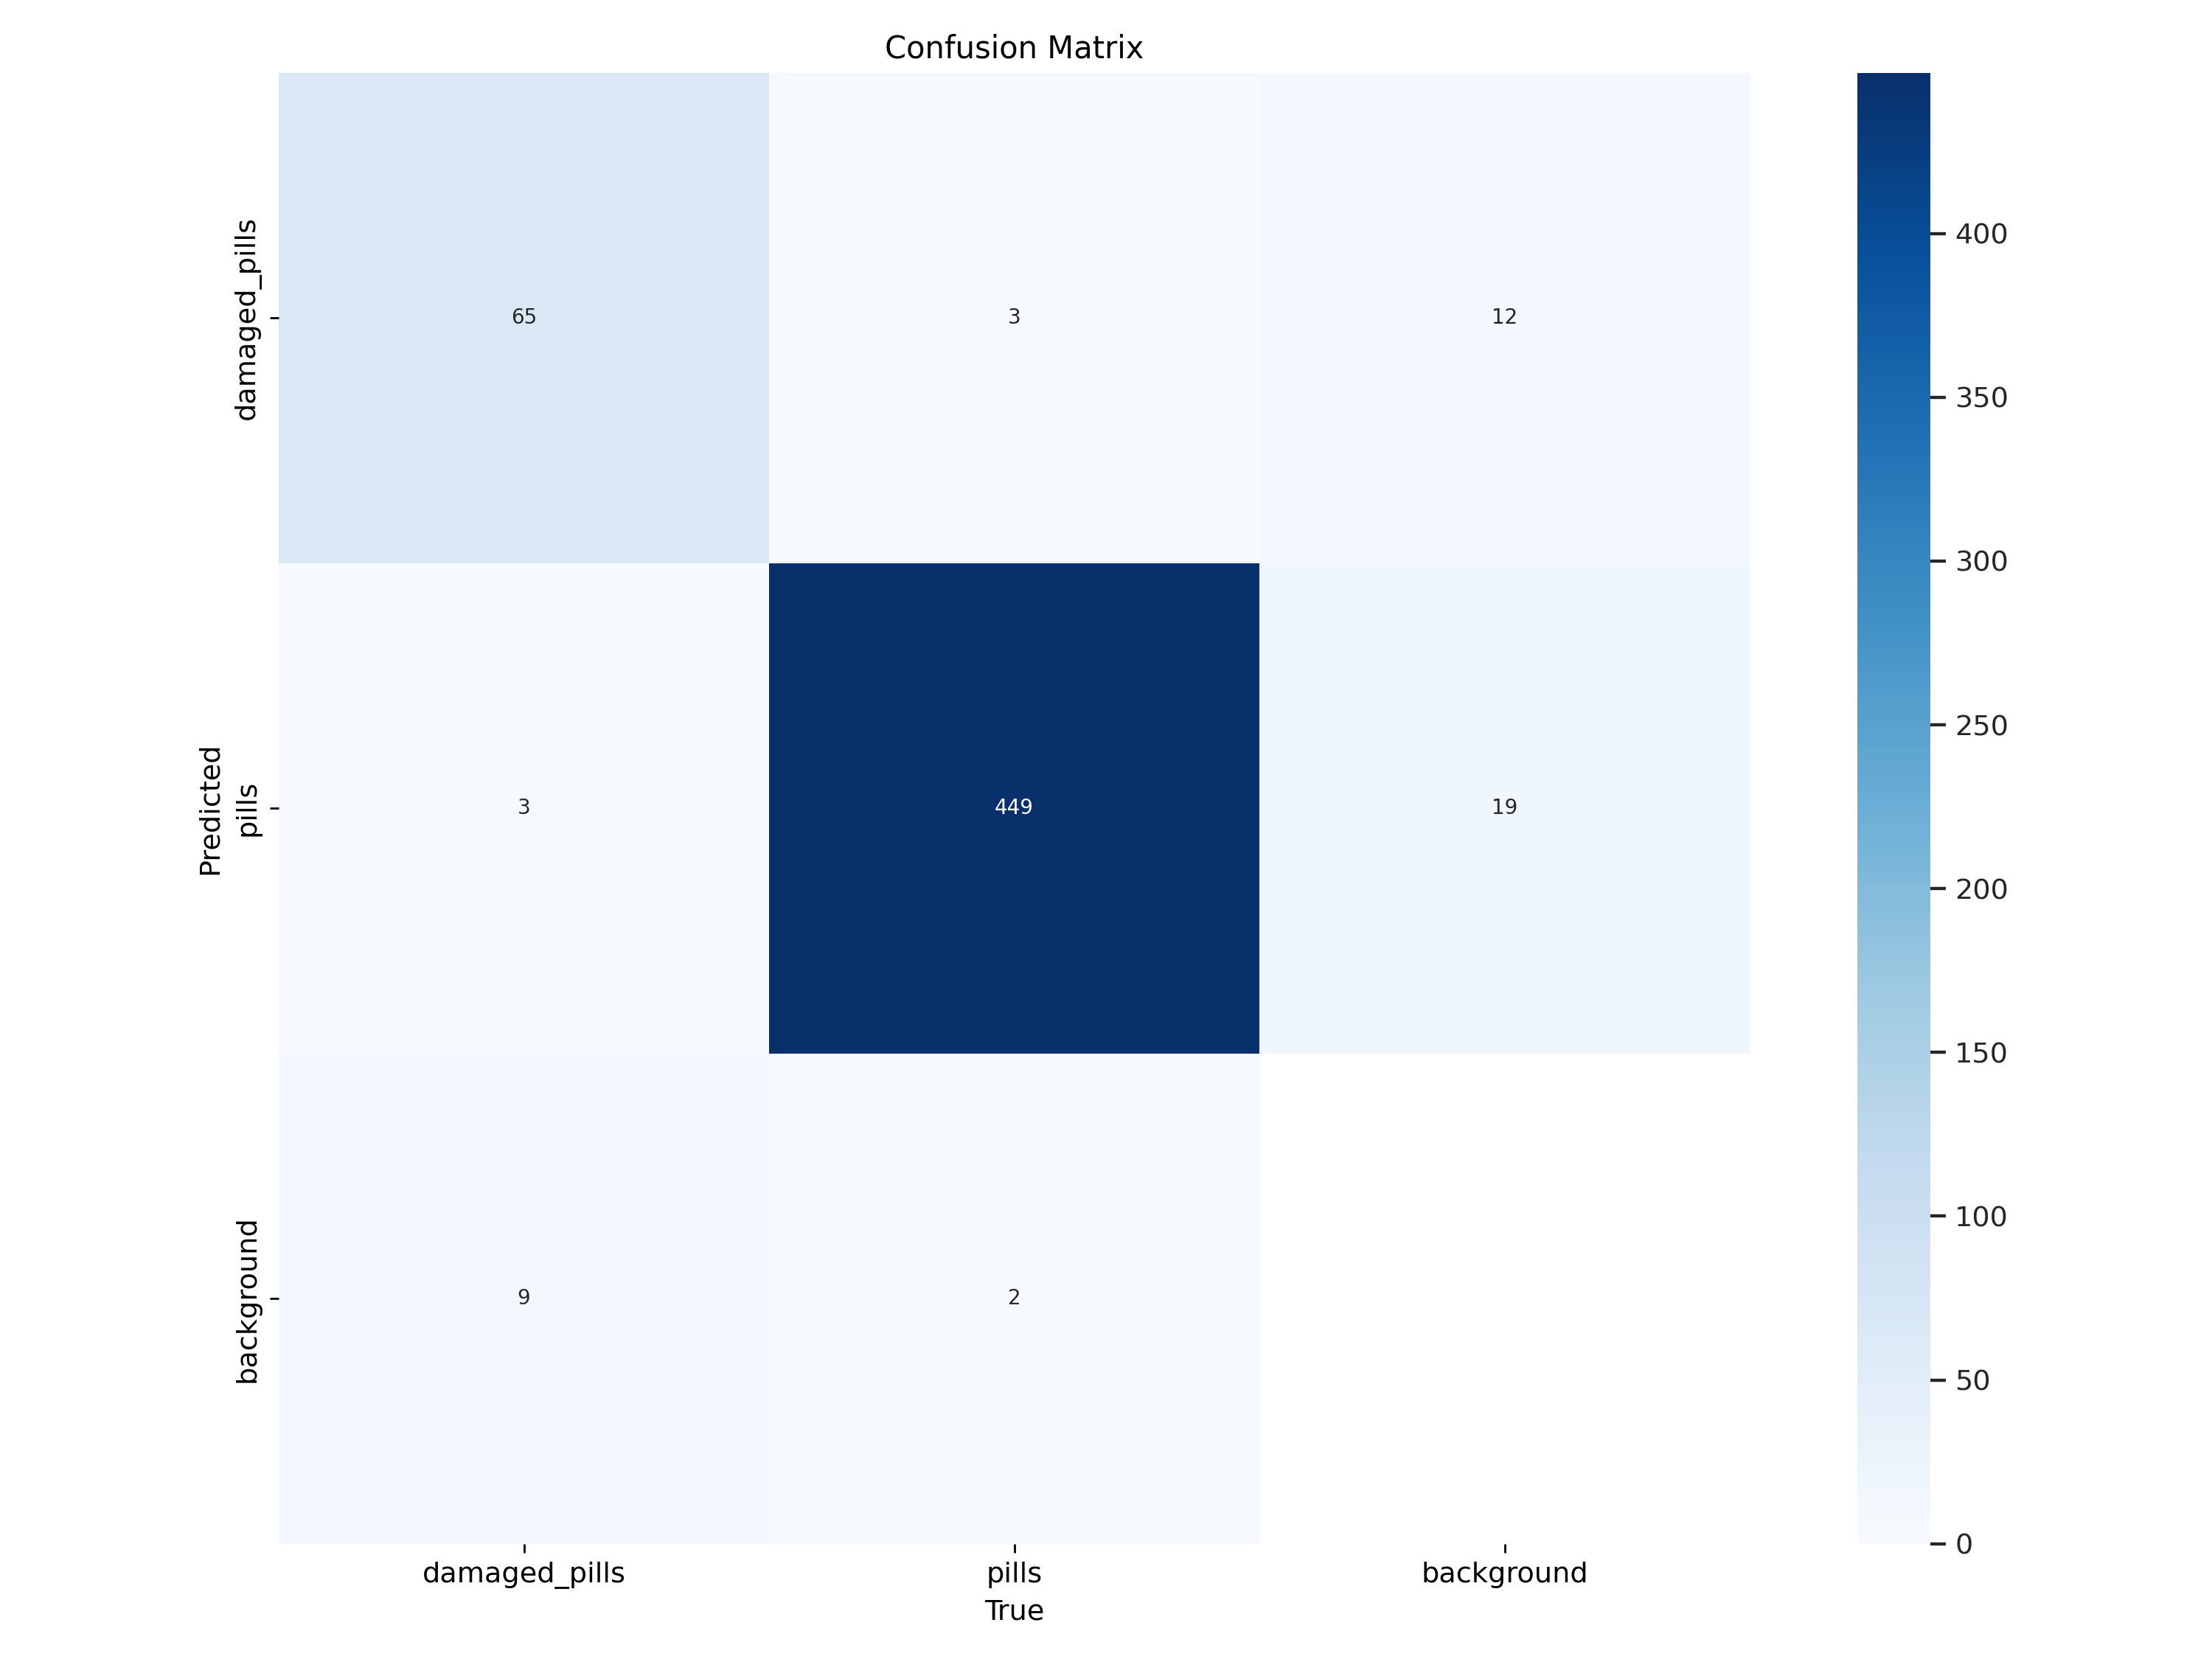

In [12]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

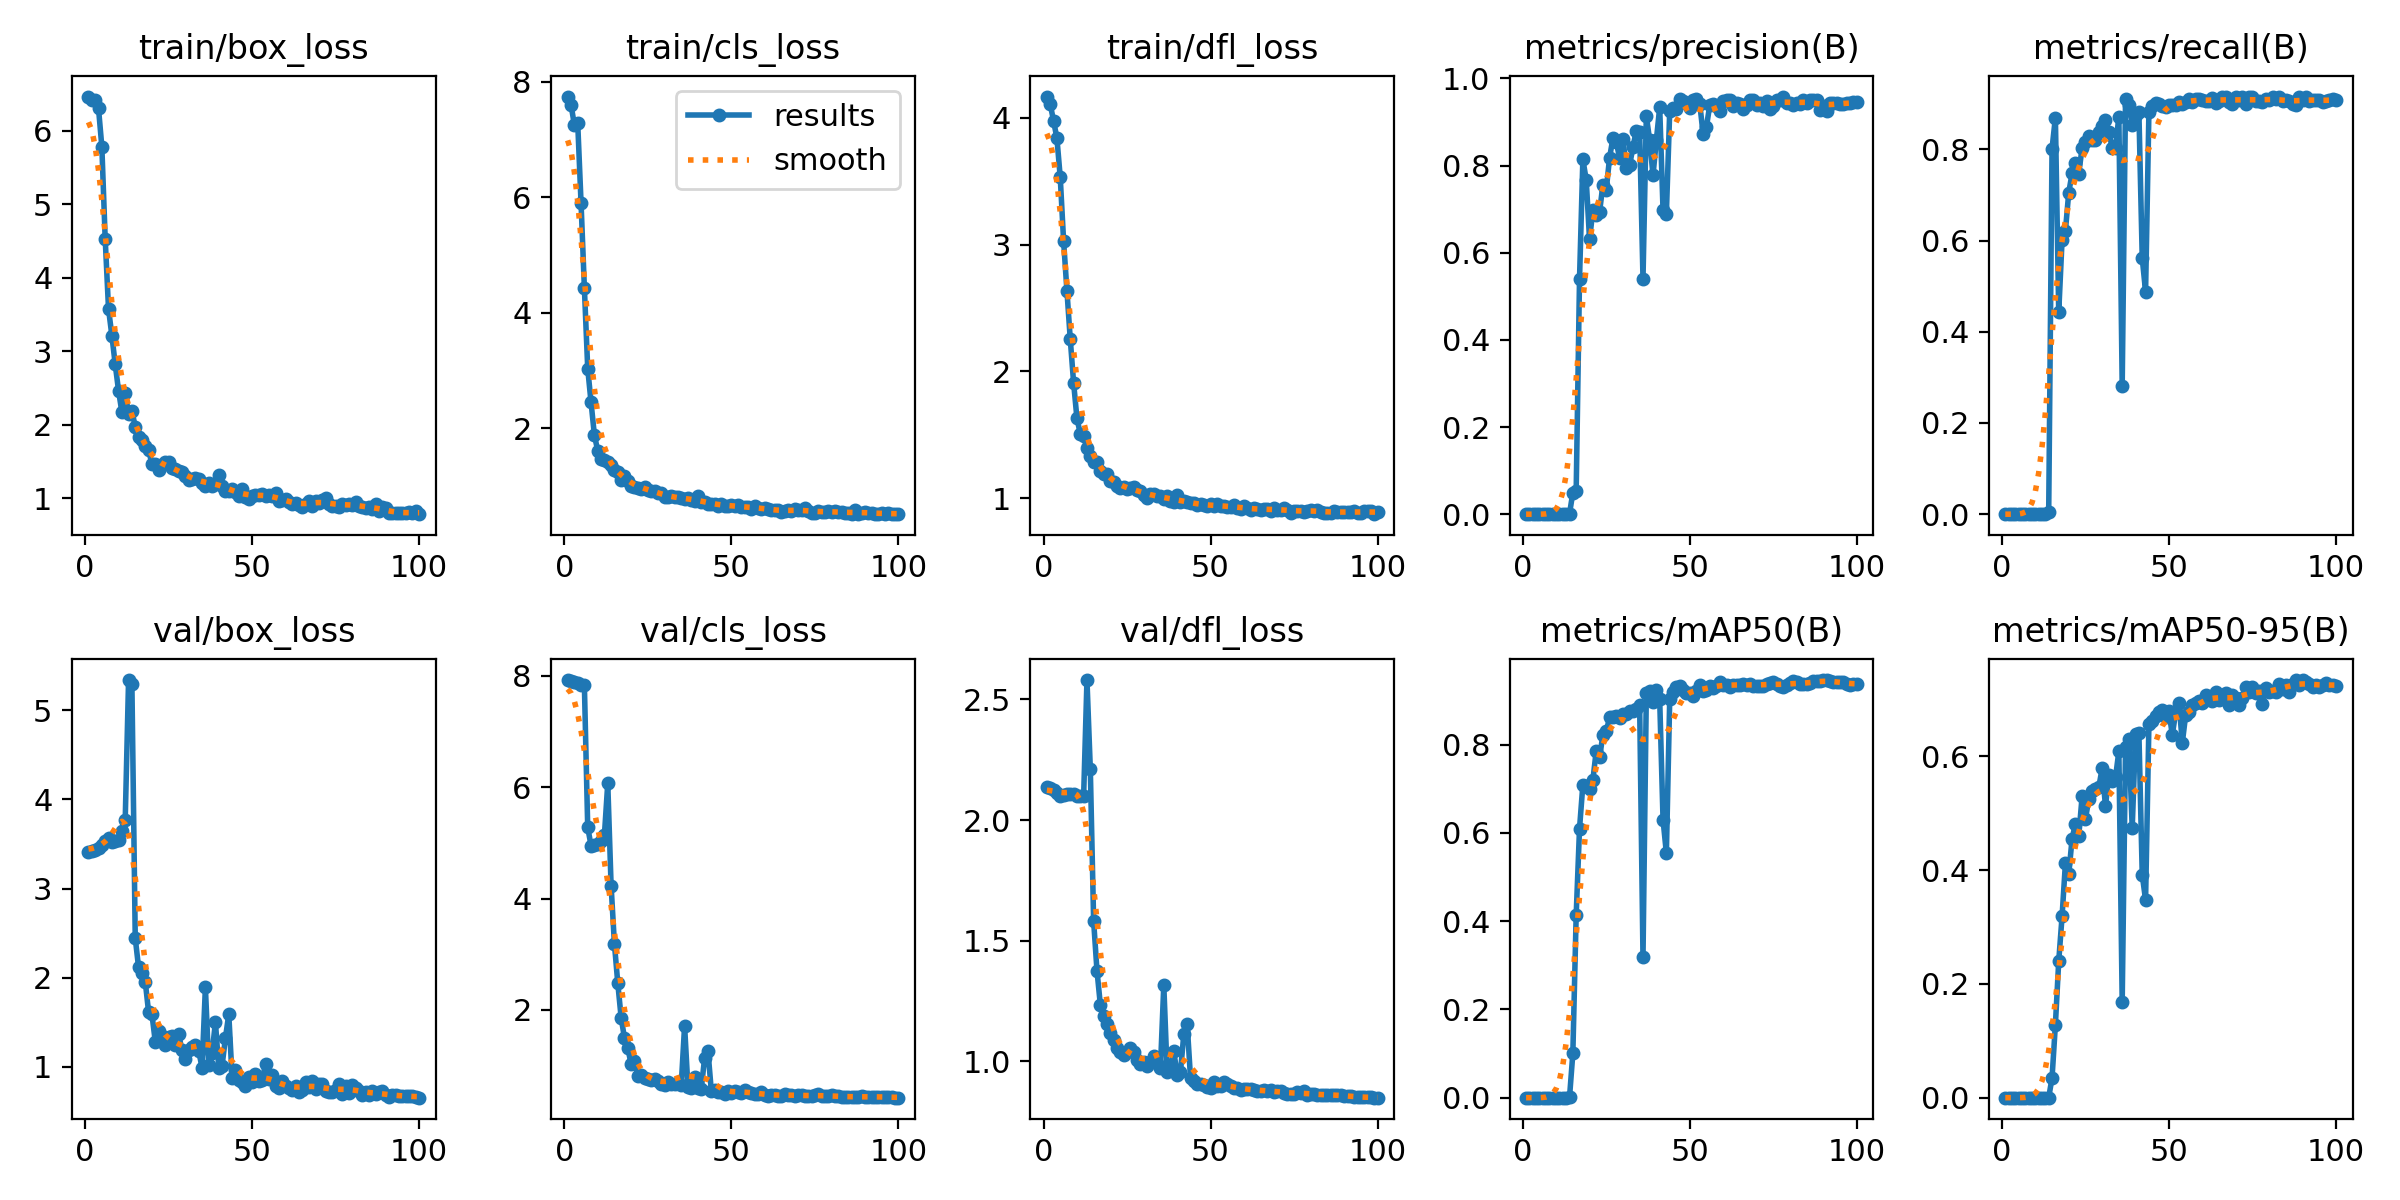

In [13]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [14]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['damaged_pills', 'pills']

In [15]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [16]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.7657480615544836
mAP 50 0.9606122844311008
mAP 75 0.9603139638354039


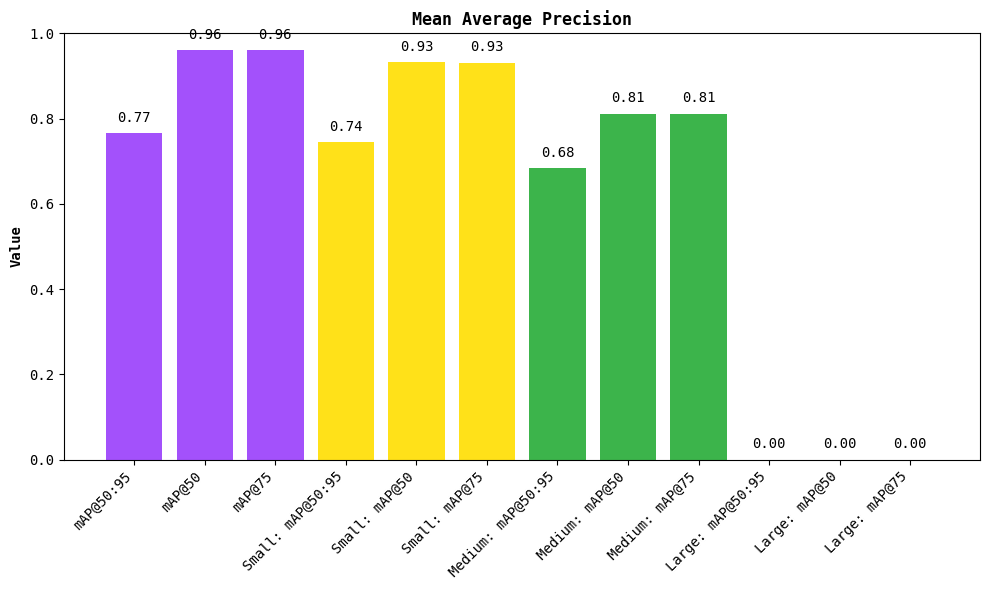

In [17]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [18]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

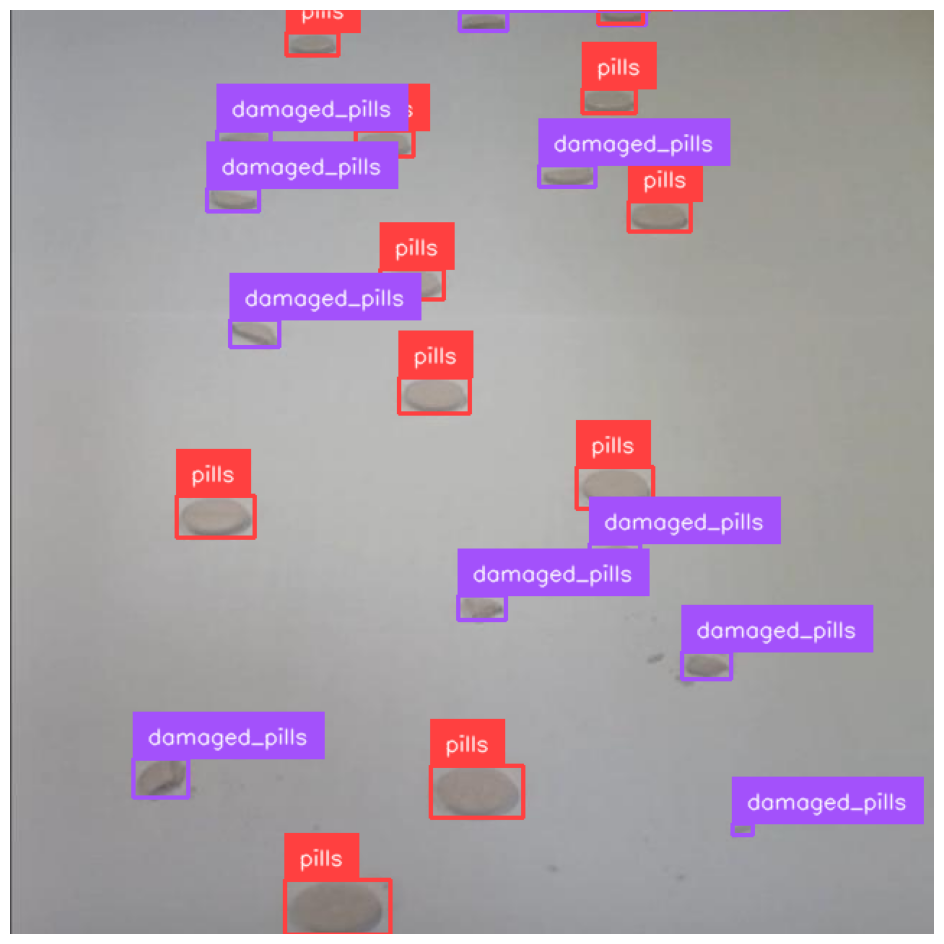

In [19]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [20]:
!ls


Pills-3  runs  sample_data  yolov12n.pt


In [26]:

!zip -r runs.z ./runs

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/train/ (stored 0%)
  adding: runs/detect/train/events.out.tfevents.1740227287.ab2afd406522.229.0 (deflated 91%)
  adding: runs/detect/train/confusion_matrix.png (deflated 33%)
  adding: runs/detect/train/train_batch1.jpg (deflated 8%)
  adding: runs/detect/train/train_batch720.jpg (deflated 12%)
  adding: runs/detect/train/args.yaml (deflated 53%)
  adding: runs/detect/train/train_batch721.jpg (deflated 13%)
  adding: runs/detect/train/val_batch0_pred.jpg (deflated 7%)
  adding: runs/detect/train/results.csv (deflated 62%)
  adding: runs/detect/train/R_curve.png (deflated 13%)
  adding: runs/detect/train/F1_curve.png (deflated 11%)
  adding: runs/detect/train/results.png (deflated 8%)
  adding: runs/detect/train/confusion_matrix_normalized.png (deflated 32%)
  adding: runs/detect/train/train_batch722.jpg (deflated 13%)
  adding: runs/detect/train/val_batch1_pred.jpg (deflated 18%)
  adding: runs/detect

In [22]:
!ls


Pills-3  runs  sample_data  yolov12n.pt
